2021.07.16 臭氧預警 複迴歸方法 9測站結果

In [146]:
import pandas as pd
import numpy as np  

# from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn import preprocessing
import statsmodels.api as sm

import sys
sys.path.append('G:\我的雲端硬碟\python')
from polib.CsvEngn import *

import seaborn as sns
sns.set(style="darkgrid")

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
mpl.rcParams['axes.unicode_minus'] = False

import datetime
import math

# EDA

## 讀檔

In [2]:
# AQI (O3_8hr、PM2.5_AVG、PM10_AVG)
bak_file_path = r"G:\我的雲端硬碟\python\output\0715\AQI_2018M1to2021M6_20210715_18.06.21.pkl"
df = read_data_dir_fPathExt(bak_file_path)
# df.head()

  >> 讀取:: G:\我的雲端硬碟\python\output\0715\AQI_2018M1to2021M6_20210715_18.06.21.pkl


In [3]:
print(df["DataCreationDate"].min())
print(df["DataCreationDate"].max())

2018-01-01 00:00:00
2021-06-30 23:00:00


In [4]:
#  air_monitor
add_file_path = r"G:\我的雲端硬碟\python\output\0715\air_monitor_2018to2021_06_20210715_14.46.08.pkl"
df_add = read_data_dir_fPathExt(add_file_path)

df_add.rename(columns={"MonitorDate":"DataCreationDate"}, inplace=True)

  >> 讀取:: G:\我的雲端硬碟\python\output\0715\air_monitor_2018to2021_06_20210715_14.46.08.pkl


In [5]:
print(df_add["DataCreationDate"].min())
print(df_add["DataCreationDate"].max())

2018-01-01 00:00:00
2021-06-30 23:00:00


In [6]:
print(len(df))

AQI_cols = ["SiteName","DataCreationDate","O3_8hr","CO_8hr","PM2.5_AVG","PM10_AVG","SO2_AVG"]
# 合併
df = df[AQI_cols].merge(df_add, how="left", on=["SiteName","DataCreationDate"])
print(len(df))

2697545
2697545


In [7]:
df.loc[:,"date"] = df.loc[:,"DataCreationDate"].dt.date

In [8]:
df.columns

Index(['SiteName', 'DataCreationDate', 'O3_8hr', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'AMB_TEMP', 'CH4', 'CO', 'CO2', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RAIN_INT', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
       'WS_HR', 'date'],
      dtype='object')

## 填補缺值 (以空品區平均取代區值)

In [9]:
# 讀取 測站基本資料
site_path = r'G:\我的雲端硬碟\work\2020\2.環保署_環境即時通專案\1.臭氧預測\空氣品質監測站基本資料.csv'
df_site = read_data_dir_fPathExt(site_path)
df_site.head()

# 串 空氣品質區
print(len(df))
df = df.merge(df_site[["SiteName", "AreaName", "SiteType"]], how="left", on="SiteName")
print(len(df))
df.columns

  >> 讀取:: G:\我的雲端硬碟\work\2020\2.環保署_環境即時通專案\1.臭氧預測\空氣品質監測站基本資料.csv
2697545
2697545


Index(['SiteName', 'DataCreationDate', 'O3_8hr', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'AMB_TEMP', 'CH4', 'CO', 'CO2', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RAIN_INT', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
       'WS_HR', 'date', 'AreaName', 'SiteType'],
      dtype='object')

In [10]:
# 依照空氣品質均計算每小時 各測值的平均
pic_cols = ["O3_8hr", "O3", "AMB_TEMP","WIND_SPEED", "CH4", "CO", "CO_8hr", "NMHC", "NO", "NO2", "NOx", "SO2", "SO2_AVG", "THC"]
gp_col = ["AreaName","DataCreationDate"]
df_gp_area_mean = df[pic_cols+gp_col].groupby(gp_col, as_index=False).mean()

<AxesSubplot:>

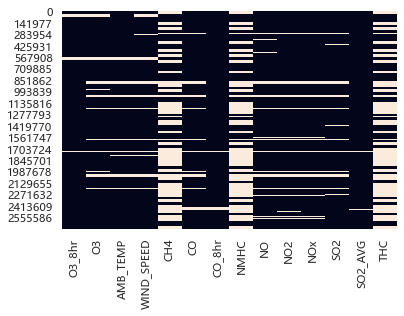

In [11]:
# 變數缺值情形
sns.heatmap(df[pic_cols].isnull(), cbar=False)

<AxesSubplot:>

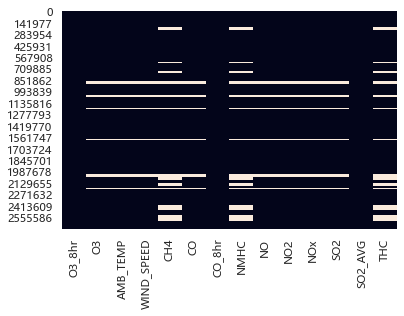

In [12]:
# 缺值以空品區平均補值
for c in pic_cols:
    mask = df[c].isnull()
    df.loc[mask, c] = df.loc[:, gp_col].merge(df_gp_area_mean[gp_col+[c]], how="left", on=gp_col).loc[mask, c]

# 變數缺值情形
sns.heatmap(df[pic_cols].isnull(), cbar=False)

## 挑選

In [34]:
# 篩選測站 & 篩選年分
site_lst = ["新店", "板橋", "古亭", "南投","竹山","埔里", "屏東","潮州","小港"]
year_min_max = [2018,2020]
pic_mask = (df["SiteName"].isin(site_lst)) & (df["DataCreationDate"].dt.year>=year_min_max[0]) & (df["DataCreationDate"].dt.year<=year_min_max[1])
df_pic = df[pic_mask].reset_index(drop=True)
df_pic.info() # CO2 在這幾個測站沒有測

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244152 entries, 0 to 244151
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   SiteName          244152 non-null  object        
 1   DataCreationDate  244152 non-null  datetime64[ns]
 2   O3_8hr            244149 non-null  float64       
 3   CO_8hr            244149 non-null  float64       
 4   PM2.5_AVG         240797 non-null  float64       
 5   PM10_AVG          239490 non-null  float64       
 6   SO2_AVG           243945 non-null  float64       
 7   AMB_TEMP          243720 non-null  float64       
 8   CH4               243720 non-null  float64       
 9   CO                243720 non-null  float64       
 10  CO2               0 non-null       float64       
 11  NMHC              243720 non-null  float64       
 12  NO                243720 non-null  float64       
 13  NO2               243720 non-null  float64       
 14  NOx 

In [35]:
# 移除遺漏值
df_pic.dropna(subset=["O3_8hr", "O3"], inplace=True)

In [15]:
# 合併 冷熱季 欄位
# 改以考量 溫度

## 變數

In [36]:
#定義實際超標門檻值
exceed_value_real = 71 #實際超標門檻值(臭氧橘警71)
df_pic.loc[:,"O3_8hr_max"] = df_pic.loc[:,["SiteName","date","O3_8hr"]].groupby(by=["SiteName","date"]).transform(max).values
df_pic.loc[:,"is_exceed_date"] = df_pic.loc[:,"O3_8hr_max"] >= exceed_value_real

# 抓出超標時間點，合併回df_pic
df_pic_real_exceed_time = df_pic[df_pic["O3_8hr"]>=exceed_value_real][["SiteName","date","DataCreationDate"]].groupby(
                                                            ["SiteName","date"], as_index=False).min()
df_pic_real_exceed_time.loc[:,"real_exceed_hour"] = df_pic_real_exceed_time.loc[:,"DataCreationDate"].dt.hour
df_pic = df_pic.merge(df_pic_real_exceed_time[["SiteName","date","real_exceed_hour"]], how="left", on=["SiteName","date"])

In [37]:
df_pic.columns

Index(['SiteName', 'DataCreationDate', 'O3_8hr', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'AMB_TEMP', 'CH4', 'CO', 'CO2', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RAIN_INT', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
       'WS_HR', 'date', 'AreaName', 'SiteType', 'O3_8hr_max', 'is_exceed_date',
       'real_exceed_hour'],
      dtype='object')

### 變數單位

In [38]:
# 讀入單位表
Unit_table_path = r"G:\我的雲端硬碟\python\output\0715\air_monitor_UnitTable_20210715_13.41.55.csv"
Unit_table = read_data_dir_fPathExt(Unit_table_path)
Unit_table

  >> 讀取:: G:\我的雲端硬碟\python\output\0715\air_monitor_UnitTable_20210715_13.41.55.csv


,_idx,ItemEngName,ItemUnit
0,0,SO2,ppb
1,1,CO,ppm
2,2,O3,ppb
3,3,PM10,μg/m3
4,4,NOx,ppb
5,5,NO,ppb
6,6,NO2,ppb
7,7,THC,ppm
8,8,NMHC,ppm
9,9,WIND_SPEED,m/sec


### 計算最大值

In [39]:
# 計算每日O3_8hr、O3最大值
cols = ["O3_8hr","O3","AMB_TEMP"]
gp_cols = ["SiteName","date"]
df_daily_max = df_pic[gp_cols+cols].groupby(by=gp_cols, as_index=False).max()
for c in cols:
    df_daily_max.rename(columns={c:f"{c}_max"}, inplace=True)
    
df_daily_max.columns

Index(['SiteName', 'date', 'O3_8hr_max', 'O3_max', 'AMB_TEMP_max'], dtype='object')

In [40]:
# df_result
df_result = df_daily_max.copy(deep=True)

### 監測因子相關

#### 每日0~7點 平均值

In [87]:
objectMean_lst = ["O3","CO","NO2","NMHC"] #前驅物

In [88]:
time_start = 0
time_end = 7

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日0~7點 小時值
mask_range = (df_pic["DataCreationDate"].dt.hour>=time_start) & (df_pic["DataCreationDate"].dt.hour<=time_end)

# 計算 平均值
gp_cols = ["SiteName","date"]
df_mean = df_pic.loc[mask_range, gp_cols+objectMean_lst].groupby(gp_cols, as_index=False).mean()

for obj in objectMean_lst:
    df_mean.rename(columns={f"{obj}":f"{obj}_{time_start}to{time_end}mean"}, inplace=True)
    
# 串回 df_result
df_mean.drop_duplicates(keep="first", inplace=True)
df_result = df_result.merge(df_mean, how="left", on=gp_cols)

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.tail()

,SiteName,date,O3_8hr_max,O3_max,AMB_TEMP_max,O3_0to7mean,CO_0to7mean,NO2_0to7mean,NMHC_0to7mean
9823,竹山,2020-12-27,31.0,39.2,24.3,8.5375,0.27875,8.4750,0.116250
9824,竹山,2020-12-28,42.0,64.9,27.4,5.8625,0.19750,5.5500,0.089107
9825,竹山,2020-12-29,45.0,72.9,26.4,5.4750,0.48125,15.4375,0.178571
9826,竹山,2020-12-30,31.0,39.7,19.3,8.4000,0.36750,11.6375,0.106071
9827,竹山,2020-12-31,26.0,28.5,11.3,25.8250,0.27500,7.3125,0.059107


In [89]:
# 整合成 df_pic5
df_pic_5 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243717 entries, 0 to 243716
Data columns (total 40 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   SiteName          243717 non-null  object        
 1   DataCreationDate  243717 non-null  datetime64[ns]
 2   O3_8hr            243717 non-null  float64       
 3   CO_8hr            243717 non-null  float64       
 4   PM2.5_AVG         240365 non-null  float64       
 5   PM10_AVG          239058 non-null  float64       
 6   SO2_AVG           243513 non-null  float64       
 7   AMB_TEMP          243717 non-null  float64       
 8   CH4               243717 non-null  float64       
 9   CO                243717 non-null  float64       
 10  CO2               0 non-null       float64       
 11  NMHC              243717 non-null  float64       
 12  NO                243717 non-null  float64       
 13  NO2               243717 non-null  float64       
 14  NOx 

O3_8hr_max       1.000000
O3_0to7mean      0.179793
CO_0to7mean      0.233518
NO2_0to7mean     0.123052
NMHC_0to7mean    0.192020
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

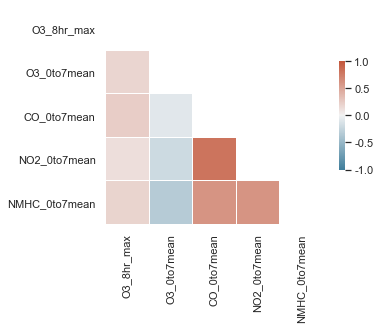

In [90]:
# 相關性
object_lst_new = [f"{obj}_{time_start}to{time_end}mean" for obj in objectMean_lst]

# normalized
feature_range = (0, 100)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=feature_range)
df_result[object_lst_new + ["O3_8hr_max"]] = min_max_scaler.fit_transform(df_result[object_lst_new + ["O3_8hr_max"]])

corr = df_result[["O3_8hr_max"]+object_lst_new].corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

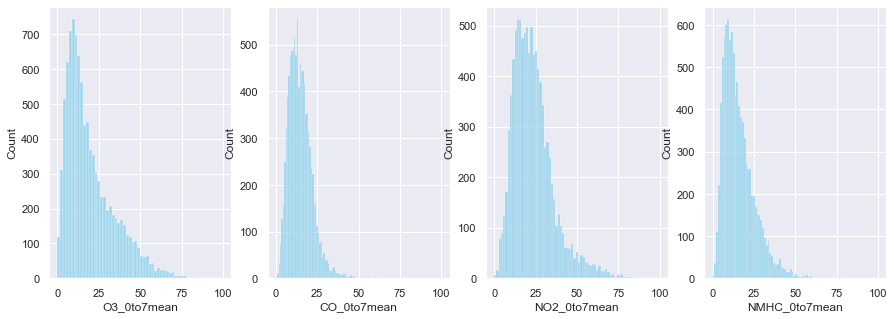

In [91]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(object_lst_new), figsize=(15, 5))

for idx, obj in enumerate(object_lst_new):
    sns.histplot(data=df_result, x=obj, kde=False, color="skyblue", ax=axs[idx])

plt.show()

In [92]:
# normalized back
df_result.loc[:,object_lst_new + ["O3_8hr_max"]] = min_max_scaler.inverse_transform(df_result.loc[:,object_lst_new + ["O3_8hr_max"]])

#### 每日1~6點 平均值

In [99]:
objectMean_lst = ["O3","CO","NO2","NMHC"] #前驅物

In [100]:
time_start = 1
time_end = 6

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日0~7點 小時值
mask_range = (df_pic["DataCreationDate"].dt.hour>=time_start) & (df_pic["DataCreationDate"].dt.hour<=time_end)

# 計算 平均值
gp_cols = ["SiteName","date"]
df_mean = df_pic.loc[mask_range, gp_cols+objectMean_lst].groupby(gp_cols, as_index=False).mean()

for obj in objectMean_lst:
    df_mean.rename(columns={f"{obj}":f"{obj}_{time_start}to{time_end}mean"}, inplace=True)
    
# 串回 df_result
df_mean.drop_duplicates(keep="first", inplace=True)
df_result = df_result.merge(df_mean, how="left", on=gp_cols)

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.tail()

,SiteName,date,O3_8hr_max,O3_max,AMB_TEMP_max,O3_1to6mean,CO_1to6mean,NO2_1to6mean,NMHC_1to6mean
9823,竹山,2020-12-27,31.0,39.2,24.3,8.950000,0.260000,7.783333,0.109762
9824,竹山,2020-12-28,42.0,64.9,27.4,5.000000,0.180000,5.316667,0.080238
9825,竹山,2020-12-29,45.0,72.9,26.4,4.733333,0.466667,15.283333,0.179048
9826,竹山,2020-12-30,31.0,39.7,19.3,7.433333,0.376667,12.283333,0.088810
9827,竹山,2020-12-31,26.0,28.5,11.3,26.250000,0.271667,7.150000,0.056905


In [101]:
# 整合成 df_pic6
df_pic_6 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243717 entries, 0 to 243716
Data columns (total 40 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   SiteName          243717 non-null  object        
 1   DataCreationDate  243717 non-null  datetime64[ns]
 2   O3_8hr            243717 non-null  float64       
 3   CO_8hr            243717 non-null  float64       
 4   PM2.5_AVG         240365 non-null  float64       
 5   PM10_AVG          239058 non-null  float64       
 6   SO2_AVG           243513 non-null  float64       
 7   AMB_TEMP          243717 non-null  float64       
 8   CH4               243717 non-null  float64       
 9   CO                243717 non-null  float64       
 10  CO2               0 non-null       float64       
 11  NMHC              243717 non-null  float64       
 12  NO                243717 non-null  float64       
 13  NO2               243717 non-null  float64       
 14  NOx 

O3_8hr_max       1.000000
O3_1to6mean      0.150588
CO_1to6mean      0.258377
NO2_1to6mean     0.137040
NMHC_1to6mean    0.194676
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

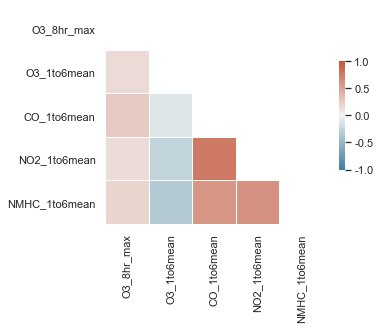

In [102]:
# 相關性
object_lst_new = [f"{obj}_{time_start}to{time_end}mean" for obj in objectMean_lst]

# normalized
feature_range = (0, 100)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=feature_range)
df_result[object_lst_new + ["O3_8hr_max"]] = min_max_scaler.fit_transform(df_result[object_lst_new + ["O3_8hr_max"]])

corr = df_result[["O3_8hr_max"]+object_lst_new].corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

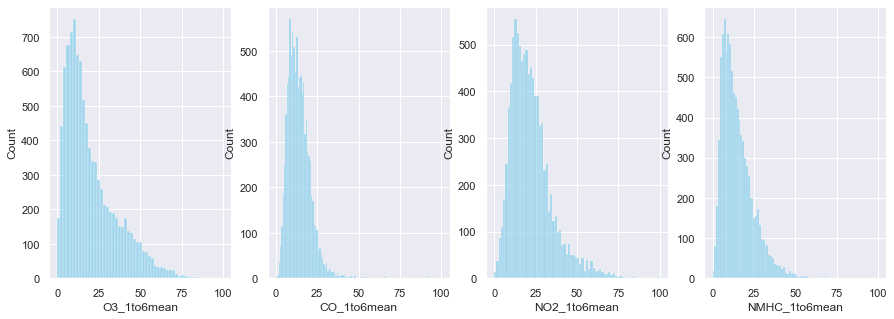

In [103]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(object_lst_new), figsize=(15, 5))

for idx, obj in enumerate(object_lst_new):
    sns.histplot(data=df_result, x=obj, kde=False, color="skyblue", ax=axs[idx])

plt.show()

In [104]:
# normalized back
df_result.loc[:,object_lst_new + ["O3_8hr_max"]] = min_max_scaler.inverse_transform(df_result.loc[:,object_lst_new + ["O3_8hr_max"]])

#### 每日0~5點 平均值 (含風速、溫度)

In [136]:
objectMean_lst = ["O3","WIND_SPEED","AMB_TEMP","CO","NMHC"] #前驅物堆積

In [137]:
time_start = 0
time_end = 5

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日0~7點 小時值
mask_range = (df_pic["DataCreationDate"].dt.hour>=time_start) & (df_pic["DataCreationDate"].dt.hour<=time_end)

# 計算 平均值
gp_cols = ["SiteName","date"]
df_mean = df_pic.loc[mask_range, gp_cols+objectMean_lst].groupby(gp_cols, as_index=False).mean()

for obj in objectMean_lst:
    df_mean.rename(columns={f"{obj}":f"{obj}_{time_start}to{time_end}mean"}, inplace=True)
    
# 串回 df_result
df_mean.drop_duplicates(keep="first", inplace=True)
df_result = df_result.merge(df_mean, how="left", on=gp_cols)

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.tail()

,SiteName,date,O3_8hr_max,O3_max,AMB_TEMP_max,O3_0to5mean,WIND_SPEED_0to5mean,AMB_TEMP_0to5mean,CO_0to5mean,NMHC_0to5mean
9823,竹山,2020-12-27,31.0,39.2,24.3,9.250000,1.050000,16.350000,0.258333,0.108571
9824,竹山,2020-12-28,42.0,64.9,27.4,6.950000,0.900000,17.816667,0.163333,0.083810
9825,竹山,2020-12-29,45.0,72.9,26.4,6.533333,0.633333,19.033333,0.451667,0.192381
9826,竹山,2020-12-30,31.0,39.7,19.3,5.383333,1.183333,18.216667,0.373333,0.114524
9827,竹山,2020-12-31,26.0,28.5,11.3,26.550000,1.416667,10.650000,0.276667,0.054524


In [138]:
# 整合成 df_pic7
df_pic_7 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243717 entries, 0 to 243716
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   SiteName             243717 non-null  object        
 1   DataCreationDate     243717 non-null  datetime64[ns]
 2   O3_8hr               243717 non-null  float64       
 3   CO_8hr               243717 non-null  float64       
 4   PM2.5_AVG            240365 non-null  float64       
 5   PM10_AVG             239058 non-null  float64       
 6   SO2_AVG              243513 non-null  float64       
 7   AMB_TEMP             243717 non-null  float64       
 8   CH4                  243717 non-null  float64       
 9   CO                   243717 non-null  float64       
 10  CO2                  0 non-null       float64       
 11  NMHC                 243717 non-null  float64       
 12  NO                   243717 non-null  float64       
 13  NO2           

O3_8hr_max             1.000000
O3_0to5mean            0.182813
WIND_SPEED_0to5mean   -0.202881
AMB_TEMP_0to5mean     -0.110218
CO_0to5mean            0.242315
NMHC_0to5mean          0.183475
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

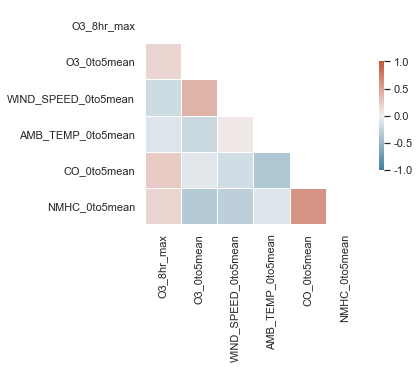

In [139]:
# 相關性
object_lst_new = [f"{obj}_{time_start}to{time_end}mean" for obj in objectMean_lst]

# normalized
feature_range = (0, 100)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=feature_range)
df_result[object_lst_new + ["O3_8hr_max"]] = min_max_scaler.fit_transform(df_result[object_lst_new + ["O3_8hr_max"]])

corr = df_result[["O3_8hr_max"]+object_lst_new].corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

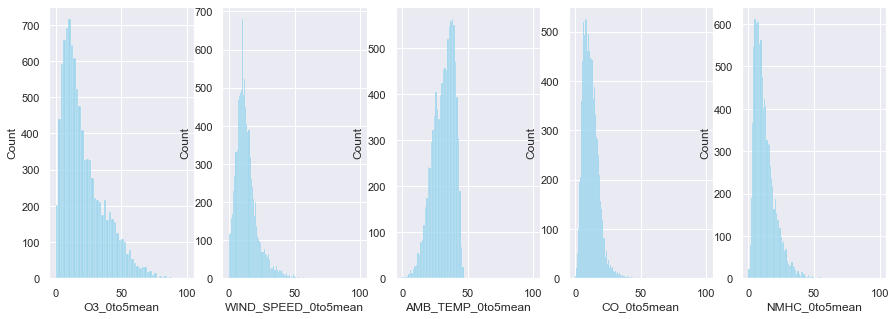

In [140]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(object_lst_new), figsize=(15, 5))

for idx, obj in enumerate(object_lst_new):
    sns.histplot(data=df_result, x=obj, kde=False, color="skyblue", ax=axs[idx])

plt.show()

In [141]:
# normalized back
df_result.loc[:,object_lst_new + ["O3_8hr_max"]] = min_max_scaler.inverse_transform(df_result.loc[:,object_lst_new + ["O3_8hr_max"]])

# Model

以2018年建模(train)、2019年驗證(test)

## (原)單變數迴歸

In [47]:
df_pic.columns

Index(['SiteName', 'DataCreationDate', 'O3_8hr', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'AMB_TEMP', 'CH4', 'CO', 'CO2', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RAIN_INT', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
       'WS_HR', 'date', 'AreaName', 'SiteType', 'O3_8hr_max', 'is_exceed_date',
       'real_exceed_hour'],
      dtype='object')

In [82]:
Site_lst = df_result["SiteName"].unique().tolist()
print(Site_lst)

['南投', '古亭', '埔里', '小港', '屏東', '新店', '板橋', '潮州', '竹山']




*******南投*******

>> Mean Absolute Error: 3.583524596979201
>> Root Mean Squared Error: 4.7515190512015835



*******南投 當年度驗證*******

*******南投*******

>>預測目標門檻值: 71

>> TN: 352
>> FP: 2
>> FN: 6
>> TP: 4

>> 預警成功率: 0.4
>> 假警報率: 0.333

>> 預警成功 發布時間點 統計:
時間點   次數
13    3
12    1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    3
4.0    1
dtype: int64
*******南投 下年度驗證*******

>>預測目標門檻值: 71

>> TN: 342
>> FP: 1
>> FN: 10
>> TP: 12

>> 預警成功率: 0.545
>> 假警報率: 0.077

>> 預警成功 發布時間點 統計:
時間點   次數
13    5
12    3
14    3
15    1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    5
4.0    4
2.0    2
5.0    1
dtype: int64


*******古亭*******

>> Mean Absolute Error: 5.344079135743446
>> Root Mean Squared Error: 6.693793653655179



*******古亭 當年度驗證*******

*******古亭*******

>>預測目標門檻值: 71

>> TN: 334
>> FP: 8
>> FN: 12
>> TP: 10

>> 預警成功率: 0.455
>> 假警報率: 0.444

>> 預警成功 發布時間點 統計:
時間點   次數
12    5
11    3
13    2
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時

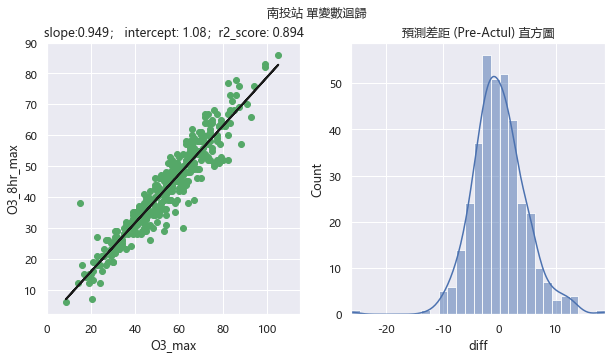

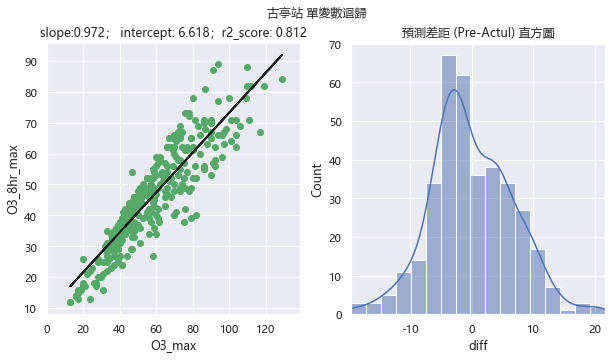

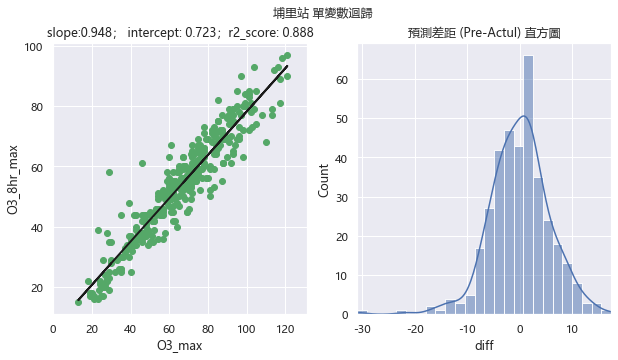

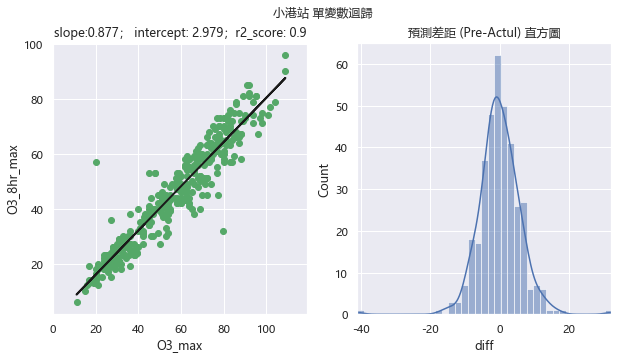

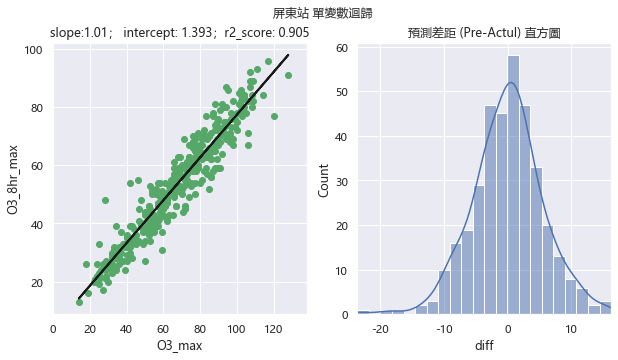

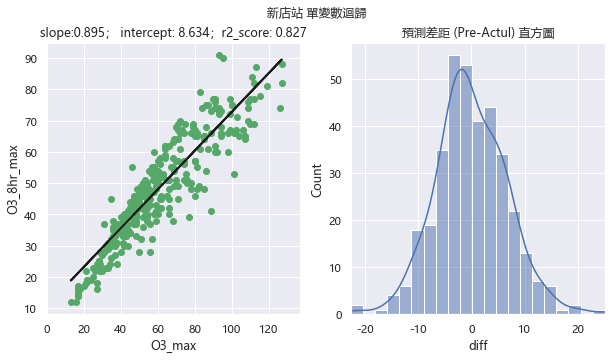

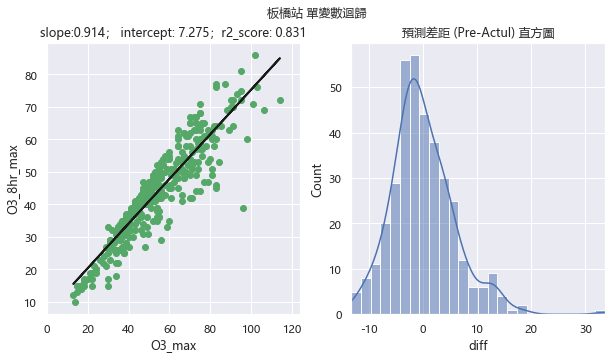

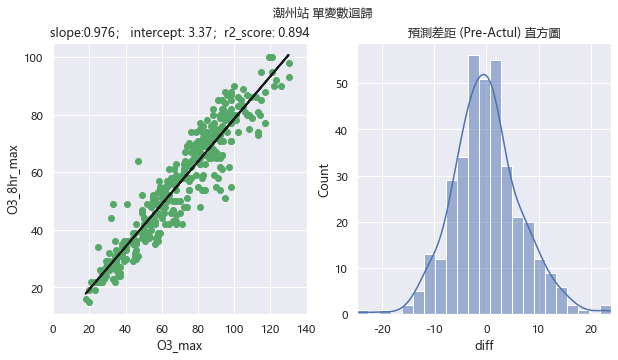

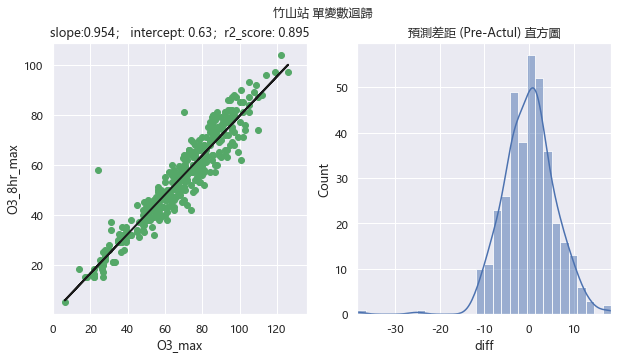

In [83]:
single_reg_diff_lst = []

for s in Site_lst:
    # mask
    mask_train = (df_result["SiteName"].isin([s])) & (df_result["date"].apply(lambda d: d.year)==2018)
    mask_test_self = (df_pic["SiteName"].isin([s])) & (df_pic["date"].apply(lambda d: d.year)==2018)
    mask_test_next = (df_pic["SiteName"].isin([s])) & (df_pic["date"].apply(lambda d: d.year)==2019)
    
    #split dataset
    #     for model
    X_train = df_result[mask_train]['O3_max'].values.reshape(-1,1) 
    y_train = df_result[mask_train]['O3_8hr_max'].values.reshape(-1,1) 

    #  for test_self
    X_test_self = df_pic[mask_test_self]['O3'].values.reshape(-1,1) 
    y_test_self = df_pic[mask_test_self]['O3_8hr'].values.reshape(-1,1)
    
    # for test_next
    X_test_next = df_pic[mask_test_next]['O3'].values.reshape(-1,1) 
    y_test_next = df_pic[mask_test_next]['O3_8hr'].values.reshape(-1,1)
    
    # normalized
    feature_range = (0, 100)
    min_max_scaler_simple_X = preprocessing.MinMaxScaler(feature_range=feature_range)
    min_max_scaler_y = preprocessing.MinMaxScaler(feature_range=feature_range)
    X_train = min_max_scaler_simple_X.fit_transform(X_train)
    y_train = min_max_scaler_y.fit_transform(y_train)
    
    # model
    reg = LinearRegression(fit_intercept=True)  
    reg.fit(X_train, y_train) # 訓練模型
    y_train_pred = reg.predict(X_train) # 預測
    
    # normalized back
    X_train = min_max_scaler_simple_X.inverse_transform(X_train)
    y_train = min_max_scaler_y.inverse_transform(y_train)
    y_train_pred = min_max_scaler_y.inverse_transform(y_train_pred)
    
    # Plot outputs
    fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,5))
    fig.suptitle(f'{s}站 單變數迴歸\n\n\n')
    
    axes[0].scatter(X_train, y_train,  color='g')
    axes[0].plot(X_train, y_train_pred, color='k', linewidth=2)
    axes[0].set_xlim(0, X_train.max()+10)
    axes[0].set_xlabel('O3_max')
    axes[0].set_ylabel('O3_8hr_max')
    axes[0].set_title(f"slope:{round(reg.coef_[0][0],3)}； intercept: {round(reg.intercept_[0],3)}；r2_score: {round(r2_score(y_train, y_train_pred),3)}")
    
    # diff hist()
    single_reg_diff = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()})
    single_reg_diff.loc[:, "diff"] = single_reg_diff.loc[: ,"Predicted"] - single_reg_diff.loc[: ,"Actual"]
    sns.histplot(data=single_reg_diff, x="diff", kde=True, ax=axes[1])
    axes[1].set_xlim(single_reg_diff.loc[:, "diff"].min(), single_reg_diff.loc[:, "diff"].max())
    axes[1].set_title(f"預測差距 (Pre-Actul) 直方圖")
    
    print(f"\n\n*******{s}*******\n")    
    print('>> Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))   
    print('>> Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    print("\n\n")
    
    #     儲存 該測站 single_reg_diff
    single_reg_diff_lst.append(single_reg_diff)


    # 當年度驗證 self
    print(f"*******{s} 當年度驗證*******\n")
    
    # normalized
    X_test_self = min_max_scaler_simple_X.transform(X_test_self)

    # 以模型預測每小時資料
    y_test_self_pred = reg.predict(X_test_self)

    # normalized back
    X_test_self = min_max_scaler_simple_X.inverse_transform(X_test_self)
    y_test_self_pred = min_max_scaler_y.inverse_transform(y_test_self_pred)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_self = df_pic[mask_test_self].reset_index(drop=True).copy(deep=True)
    df_self.loc[:,"y_pred"] = y_test_self_pred
    df_self.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_self_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_self = df_self.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")


    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_self["is_exceed_date"].values, df_self[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()
    print(f"*******{s}*******\n")

    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")


    # 計算 TP  預警時間、提早時數
    mask_TP = (df_self["is_exceed_date"].isin([True])) &(df_self[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_self[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_self[mask_TP]['real_exceed_hour']) -(df_self[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")


    # 下年度驗證 next
    print(f"*******{s} 下年度驗證*******\n")

    # normalized
    X_test_next = min_max_scaler_simple_X.transform(X_test_next)

    # 以模型預測每小時資料
    y_test_next_pred = reg.predict(X_test_next)

    # normalized back
    X_test_next = min_max_scaler_simple_X.inverse_transform(X_test_next)
    y_test_next_pred = min_max_scaler_y.inverse_transform(y_test_next_pred)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_next = df_pic[mask_test_next].reset_index(drop=True).copy(deep=True)
    df_next.loc[:,"y_pred"] = y_test_next_pred
    df_next.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_next_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_next = df_next.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_next["is_exceed_date"].values, df_next[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_next["is_exceed_date"].isin([True])) &(df_next[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_next[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_next[mask_TP]['real_exceed_hour']) -(df_next[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

In [84]:
len(single_reg_diff_lst)

9

## 複迴歸測試

### 參數設定(+0to7_Mean)

In [93]:
object_lst_new

['O3_0to7mean', 'CO_0to7mean', 'NO2_0to7mean', 'NMHC_0to7mean']

In [94]:
# 變數設定 (for df_pic_5)
X_col_model = ['O3_max', "O3_0to7mean","CO_0to7mean","NO2_0to7mean","NMHC_0to7mean"]
X_col_test = ['O3',"O3_0to7mean","CO_0to7mean","NO2_0to7mean","NMHC_0to7mean"]
df_pic_for_model = df_pic_5.copy(deep=True)

In [95]:
# 刪除遺漏值
df_result.dropna(subset=X_col_model+["O3_8hr_max"], how='any', inplace=True)

print(f">> 刪除row數: {len(df_pic_for_model) - len(df_pic_for_model.dropna(subset=X_col_test+['O3_8hr_max'], how='any'))}")
df_pic_for_model.dropna(subset=X_col_test+["O3_8hr_max"], how='any', inplace=True)

df_pic_for_model.columns

>> 刪除row數: 144


Index(['SiteName', 'DataCreationDate', 'O3_8hr', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'AMB_TEMP', 'CH4', 'CO', 'CO2', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RAIN_INT', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
       'WS_HR', 'date', 'AreaName', 'SiteType', 'O3_8hr_max', 'is_exceed_date',
       'real_exceed_hour', 'AMB_TEMP_max', 'O3_0to7mean', 'CO_0to7mean',
       'NO2_0to7mean', 'NMHC_0to7mean'],
      dtype='object')

>> X:['O3_max', 'O3_0to7mean', 'CO_0to7mean', 'NO2_0to7mean', 'NMHC_0to7mean']
>> slope:[[ 0.95136909  0.06661731  0.01560433 -0.06406451  0.01597109]]
>> pvalue:[0.0, 0.0, 0.575, 0.05, 0.578]
>> intercept: 0.46
>> r2_score: 0.901

>> Mean Absolute Error: 3.4168055215704083
>> Root Mean Squared Error: 4.600482602210738


*******南投 當年度驗證*******

>>預測目標門檻值: 71

>> TN: 353
>> FP: 1
>> FN: 5
>> TP: 5

>> 預警成功率: 0.5
>> 假警報率: 0.167

>> 預警成功 發布時間點 統計:
時間點   次數
13    5
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    4
2.0    1
dtype: int64
*******南投 下年度驗證*******

>>預測目標門檻值: 71

>> TN: 342
>> FP: 1
>> FN: 8
>> TP: 14

>> 預警成功率: 0.636
>> 假警報率: 0.067

>> 預警成功 發布時間點 統計:
時間點   次數
13    5
14    5
12    3
15    1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    7
4.0    4
2.0    2
5.0    1
dtype: int64
>> X:['O3_max', 'O3_0to7mean', 'CO_0to7mean', 'NO2_0to7mean', 'NMHC_0to7mean']
>> slope:[[ 0.97324793  0.2903078  -0.00350474  0.18315065 -0.1859074 ]]
>> p

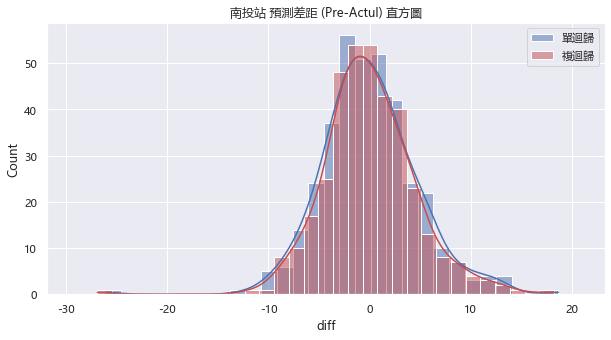

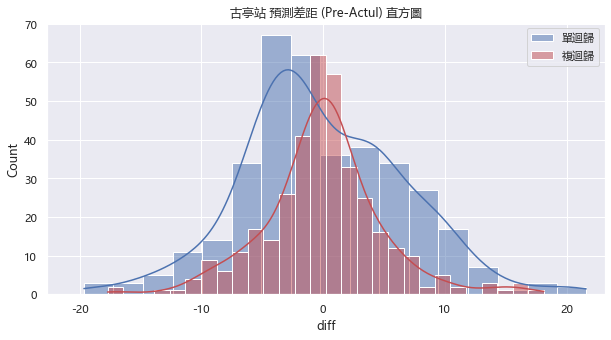

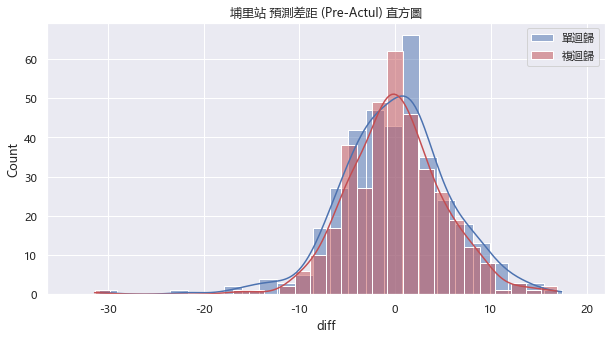

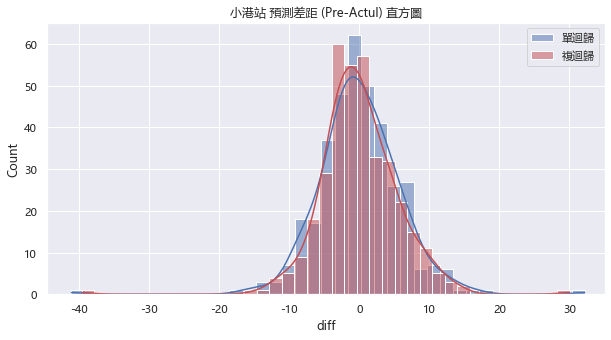

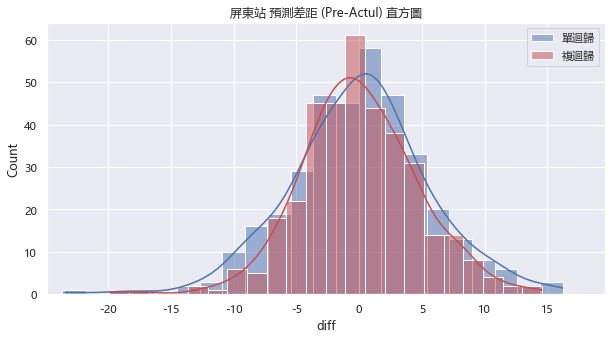

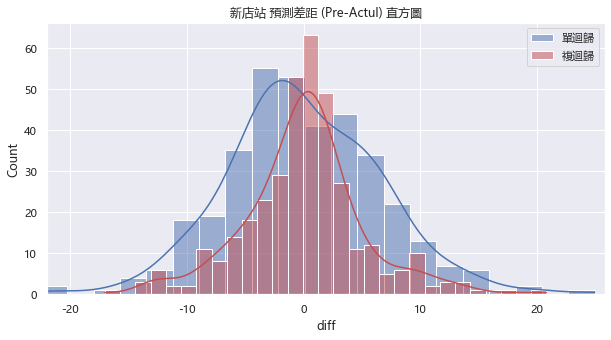

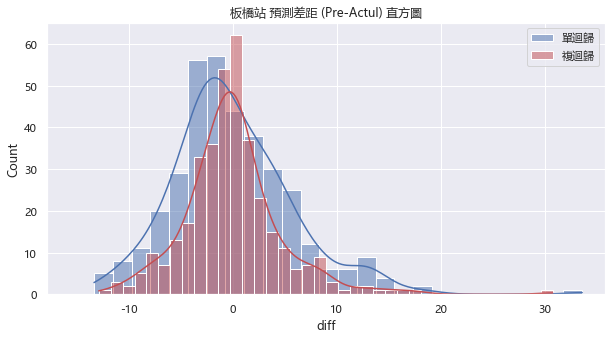

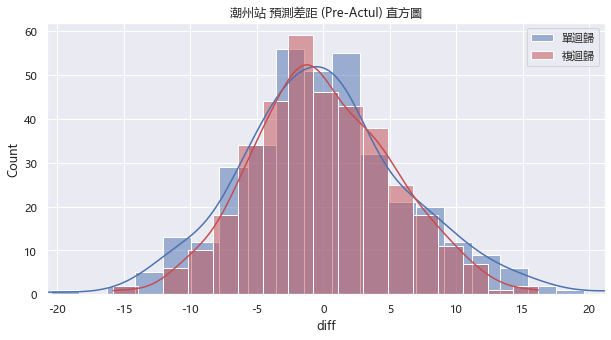

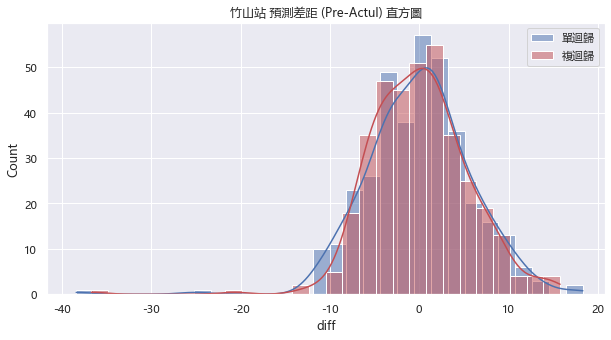

In [98]:
for s, single_reg_diff in zip(Site_lst, single_reg_diff_lst):
    # mask
    mask_train = (df_result["SiteName"].isin([s])) & (df_result["date"].apply(lambda d: d.year)==2018)
    mask_test_self = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2018)
    mask_test_next = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2019)
    
    #split dataset
    #     for model
    X_train = df_result[mask_train][X_col_model].values
    y_train = df_result[mask_train]['O3_8hr_max'].values.reshape(-1,1) 

    #  for test_self
    X_test_self = df_pic_for_model[mask_test_self][X_col_test].values
    y_test_self = df_pic_for_model[mask_test_self]['O3_8hr'].values.reshape(-1,1)
    
    # for test_next
    X_test_next = df_pic_for_model[mask_test_next][X_col_test].values
    y_test_next = df_pic_for_model[mask_test_next]['O3_8hr'].values.reshape(-1,1)
    
    # normalized
    feature_range = (0, 100)
    min_max_scaler_multi_X = preprocessing.MinMaxScaler(feature_range=feature_range)
    min_max_scaler_y = preprocessing.MinMaxScaler(feature_range=feature_range)
    X_train = min_max_scaler_multi_X.fit_transform(X_train)
    y_train = min_max_scaler_y.fit_transform(y_train)
    
    # model
    reg = LinearRegression(fit_intercept=True)  
    reg.fit(X_train, y_train) # 訓練模型
    y_train_pred = reg.predict(X_train) # 預測
    
    # model summery by statsmodels.api as sm
    X_train_2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X_train_2)
    est2 = est.fit()
    
    # normalized back
    X_train = min_max_scaler_multi_X.inverse_transform(X_train)
    y_train = min_max_scaler_y.inverse_transform(y_train)
    y_train_pred = min_max_scaler_y.inverse_transform(y_train_pred)
    

    
    # Print outputs
    print(f">> X:{X_col_model}")
    print(f">> slope:{reg.coef_}")
    print(f">> pvalue:{est2.pvalues.round(3)[1:].tolist()}")
    print(f">> intercept: {round(reg.intercept_[0],3)}")
    print(f">> r2_score: {round(r2_score(y_train, y_train_pred),3)}\n")
#     print(est2.summary())
    
    
    # 單變數迴歸 diff: single_reg_diff
    
    # 複迴歸 diff: mutil_reg_diff
    mutil_reg_diff = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()})
    mutil_reg_diff.loc[:, "diff"] = mutil_reg_diff.loc[: ,"Predicted"] - mutil_reg_diff.loc[: ,"Actual"]

    # 疊圖
    fig, ax = plt.subplots(figsize=(10,5))
    for idx, d in enumerate([single_reg_diff, mutil_reg_diff]):
        if idx==1:
            color = 'r'
            label = "複迴歸"
        else:
            color = 'b'
            label = "單迴歸"
            
        sns.histplot(data=d, x="diff" ,ax=ax, kde=True, color=color, label=label)
    ax.set_xlim(mutil_reg_diff.loc[:, "diff"].min()-5, mutil_reg_diff.loc[:, "diff"].max()+5)
    ax.legend()
    ax.set_title(f"{s}站 預測差距 (Pre-Actul) 直方圖")
    
    print('>> Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))   
    print('>> Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    print(f"\n")

    # 當年度驗證
    print(f"*******{s} 當年度驗證*******\n")

    # normalized
    X_test_self = min_max_scaler_multi_X.transform(X_test_self)

    # 以模型預測每小時資料
    y_test_self_pred = reg.predict(X_test_self)

    # normalized back
    X_test_self = min_max_scaler_multi_X.inverse_transform(X_test_self)
    y_test_self_pred = min_max_scaler_y.inverse_transform(y_test_self_pred)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_self = df_pic_for_model[mask_test_self].reset_index(drop=True).copy(deep=True)
    df_self.loc[:,"y_pred"] = y_test_self_pred
    df_self.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_self_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_self = df_self.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_self["is_exceed_date"].values, df_self[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()
    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_self["is_exceed_date"].isin([True])) &(df_self[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_self[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_self[mask_TP]['real_exceed_hour']) -(df_self[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

    # 下年度驗證
    print(f"*******{s} 下年度驗證*******\n")

    # normalized
    X_test_next = min_max_scaler_multi_X.transform(X_test_next)

    # 以模型預測每小時資料
    y_test_next_pred = reg.predict(X_test_next)

    # normalized back
    X_test_next = min_max_scaler_multi_X.inverse_transform(X_test_next)
    y_test_next_pred = min_max_scaler_y.inverse_transform(y_test_next_pred)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_next = df_pic_for_model[mask_test_next].reset_index(drop=True).copy(deep=True)
    df_next.loc[:,"y_pred"] = y_test_next_pred
    df_next.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_next_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_next = df_next.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_next["is_exceed_date"].values, df_next[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_next["is_exceed_date"].isin([True])) &(df_next[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_next[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_next[mask_TP]['real_exceed_hour']) -(df_next[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

### 參數設定(+1to6_Mean)

In [105]:
# 變數設定 (for df_pic_6)
X_col_model = ['O3_max', 'O3_1to6mean', 'CO_1to6mean', 'NO2_1to6mean', 'NMHC_1to6mean']
X_col_test = ['O3','O3_1to6mean', 'CO_1to6mean', 'NO2_1to6mean', 'NMHC_1to6mean']
df_pic_for_model = df_pic_6.copy(deep=True)

In [106]:
# 刪除遺漏值
df_result.dropna(subset=X_col_model+["O3_8hr_max"], how='any', inplace=True)

print(f">> 刪除row數: {len(df_pic_for_model) - len(df_pic_for_model.dropna(subset=X_col_test+['O3_8hr_max'], how='any'))}")
df_pic_for_model.dropna(subset=X_col_test+["O3_8hr_max"], how='any', inplace=True)

df_pic_for_model.columns

>> 刪除row數: 171


Index(['SiteName', 'DataCreationDate', 'O3_8hr', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'AMB_TEMP', 'CH4', 'CO', 'CO2', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RAIN_INT', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
       'WS_HR', 'date', 'AreaName', 'SiteType', 'O3_8hr_max', 'is_exceed_date',
       'real_exceed_hour', 'AMB_TEMP_max', 'O3_1to6mean', 'CO_1to6mean',
       'NO2_1to6mean', 'NMHC_1to6mean'],
      dtype='object')

>> X:['O3_max', 'O3_1to6mean', 'CO_1to6mean', 'NO2_1to6mean', 'NMHC_1to6mean']
>> slope:[[ 0.95468569  0.0535099   0.01237221 -0.05291225  0.00974897]]
>> pvalue:[0.0, 0.003, 0.647, 0.105, 0.737]
>> intercept: 0.512
>> r2_score: 0.899

>> Mean Absolute Error: 3.457434244869465
>> Root Mean Squared Error: 4.640209708662672


*******南投 當年度驗證*******

>>預測目標門檻值: 71

>> TN: 353
>> FP: 1
>> FN: 6
>> TP: 4

>> 預警成功率: 0.4
>> 假警報率: 0.2

>> 預警成功 發布時間點 統計:
時間點   次數
13    4
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    4
dtype: int64
*******南投 下年度驗證*******

>>預測目標門檻值: 71

>> TN: 342
>> FP: 1
>> FN: 8
>> TP: 14

>> 預警成功率: 0.636
>> 假警報率: 0.067

>> 預警成功 發布時間點 統計:
時間點   次數
13    5
14    5
12    3
15    1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    7
4.0    4
2.0    2
5.0    1
dtype: int64
>> X:['O3_max', 'O3_1to6mean', 'CO_1to6mean', 'NO2_1to6mean', 'NMHC_1to6mean']
>> slope:[[ 0.97622751  0.27454417  0.03221405  0.18541503 -0.21487559]]
>> pvalue:[0

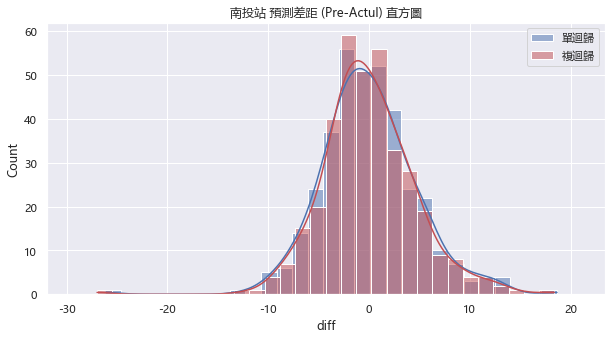

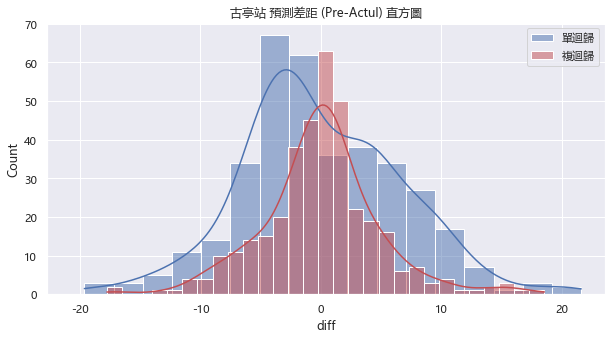

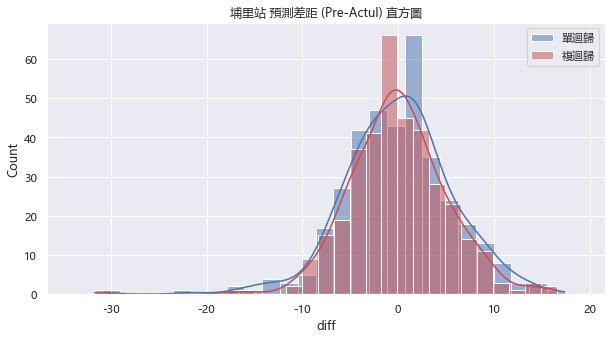

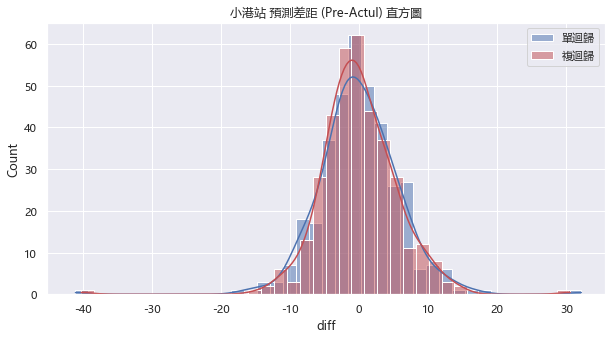

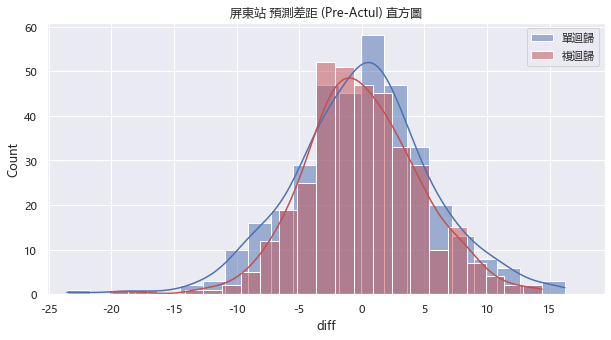

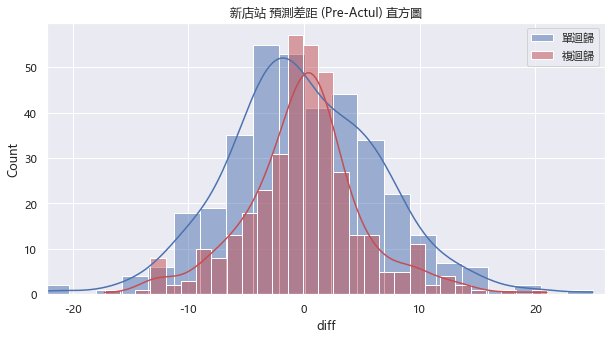

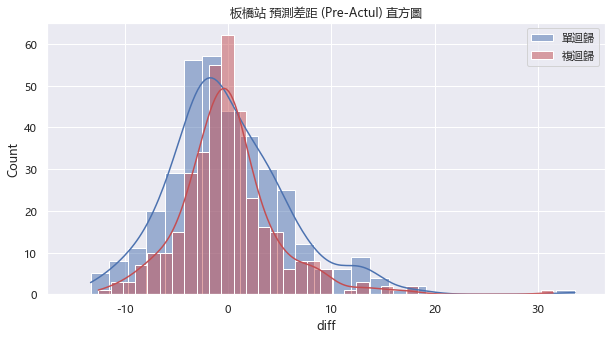

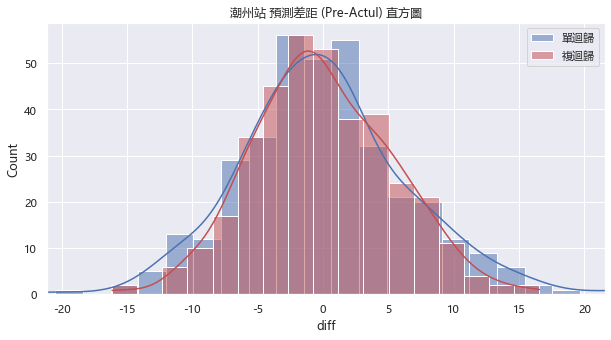

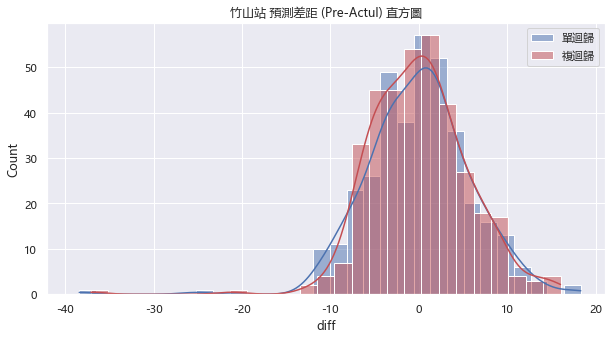

In [109]:
for s, single_reg_diff in zip(Site_lst, single_reg_diff_lst):
    # mask
    mask_train = (df_result["SiteName"].isin([s])) & (df_result["date"].apply(lambda d: d.year)==2018)
    mask_test_self = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2018)
    mask_test_next = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2019)
    
    #split dataset
    #     for model
    X_train = df_result[mask_train][X_col_model].values
    y_train = df_result[mask_train]['O3_8hr_max'].values.reshape(-1,1) 

    #  for test_self
    X_test_self = df_pic_for_model[mask_test_self][X_col_test].values
    y_test_self = df_pic_for_model[mask_test_self]['O3_8hr'].values.reshape(-1,1)
    
    # for test_next
    X_test_next = df_pic_for_model[mask_test_next][X_col_test].values
    y_test_next = df_pic_for_model[mask_test_next]['O3_8hr'].values.reshape(-1,1)
    
    # normalized
    feature_range = (0, 100)
    min_max_scaler_multi_X = preprocessing.MinMaxScaler(feature_range=feature_range)
    min_max_scaler_y = preprocessing.MinMaxScaler(feature_range=feature_range)
    X_train = min_max_scaler_multi_X.fit_transform(X_train)
    y_train = min_max_scaler_y.fit_transform(y_train)
    
    # model
    reg = LinearRegression(fit_intercept=True)  
    reg.fit(X_train, y_train) # 訓練模型
    y_train_pred = reg.predict(X_train) # 預測
    
    # model summery by statsmodels.api as sm
    X_train_2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X_train_2)
    est2 = est.fit()
    
    # normalized back
    X_train = min_max_scaler_multi_X.inverse_transform(X_train)
    y_train = min_max_scaler_y.inverse_transform(y_train)
    y_train_pred = min_max_scaler_y.inverse_transform(y_train_pred)
    

    
    # Print outputs
    print(f">> X:{X_col_model}")
    print(f">> slope:{reg.coef_}")
    print(f">> pvalue:{est2.pvalues.round(3)[1:].tolist()}")
    print(f">> intercept: {round(reg.intercept_[0],3)}")
    print(f">> r2_score: {round(r2_score(y_train, y_train_pred),3)}\n")
#     print(est2.summary())
    
    
    # 單變數迴歸 diff: single_reg_diff
    
    # 複迴歸 diff: mutil_reg_diff
    mutil_reg_diff = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()})
    mutil_reg_diff.loc[:, "diff"] = mutil_reg_diff.loc[: ,"Predicted"] - mutil_reg_diff.loc[: ,"Actual"]

    # 疊圖
    fig, ax = plt.subplots(figsize=(10,5))
    for idx, d in enumerate([single_reg_diff, mutil_reg_diff]):
        if idx==1:
            color = 'r'
            label = "複迴歸"
        else:
            color = 'b'
            label = "單迴歸"
            
        sns.histplot(data=d, x="diff" ,ax=ax, kde=True, color=color, label=label)
    ax.set_xlim(mutil_reg_diff.loc[:, "diff"].min()-5, mutil_reg_diff.loc[:, "diff"].max()+5)
    ax.legend()
    ax.set_title(f"{s}站 預測差距 (Pre-Actul) 直方圖")
    
    print('>> Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))   
    print('>> Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    print(f"\n")

    # 當年度驗證
    print(f"*******{s} 當年度驗證*******\n")

    # normalized
    X_test_self = min_max_scaler_multi_X.transform(X_test_self)

    # 以模型預測每小時資料
    y_test_self_pred = reg.predict(X_test_self)

    # normalized back
    X_test_self = min_max_scaler_multi_X.inverse_transform(X_test_self)
    y_test_self_pred = min_max_scaler_y.inverse_transform(y_test_self_pred)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_self = df_pic_for_model[mask_test_self].reset_index(drop=True).copy(deep=True)
    df_self.loc[:,"y_pred"] = y_test_self_pred
    df_self.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_self_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_self = df_self.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_self["is_exceed_date"].values, df_self[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()
    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_self["is_exceed_date"].isin([True])) &(df_self[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_self[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_self[mask_TP]['real_exceed_hour']) -(df_self[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

    # 下年度驗證
    print(f"*******{s} 下年度驗證*******\n")

    # normalized
    X_test_next = min_max_scaler_multi_X.transform(X_test_next)

    # 以模型預測每小時資料
    y_test_next_pred = reg.predict(X_test_next)

    # normalized back
    X_test_next = min_max_scaler_multi_X.inverse_transform(X_test_next)
    y_test_next_pred = min_max_scaler_y.inverse_transform(y_test_next_pred)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_next = df_pic_for_model[mask_test_next].reset_index(drop=True).copy(deep=True)
    df_next.loc[:,"y_pred"] = y_test_next_pred
    df_next.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_next_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_next = df_next.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_next["is_exceed_date"].values, df_next[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_next["is_exceed_date"].isin([True])) &(df_next[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_next[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_next[mask_TP]['real_exceed_hour']) -(df_next[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

### 參數設定(+0to5_Mean 含風速、溫度)

In [142]:
object_lst_new

['O3_0to5mean',
 'WIND_SPEED_0to5mean',
 'AMB_TEMP_0to5mean',
 'CO_0to5mean',
 'NMHC_0to5mean']

In [143]:
# 變數設定 (for df_pic_7)
X_col_model = ['O3_max', 'O3_0to5mean', 'WIND_SPEED_0to5mean', 'AMB_TEMP_0to5mean', 'CO_0to5mean','NMHC_0to5mean']
X_col_test = ['O3', 'O3_0to5mean', 'WIND_SPEED_0to5mean', 'AMB_TEMP_0to5mean', 'CO_0to5mean','NMHC_0to5mean']
df_pic_for_model = df_pic_7.copy(deep=True)

In [144]:
# 刪除遺漏值
df_result.dropna(subset=X_col_model+["O3_8hr_max"], how='any', inplace=True)

print(f">> 刪除row數: {len(df_pic_for_model) - len(df_pic_for_model.dropna(subset=X_col_test+['O3_8hr_max'], how='any'))}")
df_pic_for_model.dropna(subset=X_col_test+["O3_8hr_max"], how='any', inplace=True)

df_pic_for_model.columns

>> 刪除row數: 306


Index(['SiteName', 'DataCreationDate', 'O3_8hr', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'AMB_TEMP', 'CH4', 'CO', 'CO2', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RAIN_INT', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
       'WS_HR', 'date', 'AreaName', 'SiteType', 'O3_8hr_max', 'is_exceed_date',
       'real_exceed_hour', 'AMB_TEMP_max', 'O3_0to5mean',
       'WIND_SPEED_0to5mean', 'AMB_TEMP_0to5mean', 'CO_0to5mean',
       'NMHC_0to5mean'],
      dtype='object')

>> X:['O3_max', 'O3_0to5mean', 'WIND_SPEED_0to5mean', 'AMB_TEMP_0to5mean', 'CO_0to5mean', 'NMHC_0to5mean']
>> slope:[[ 0.945985    0.07509548 -0.00252408  0.03252135  0.00592583 -0.00722261]]
>> pvalue:[0.0, 0.0, 0.922, 0.065, 0.811, 0.751]
>> intercept: -2.682
>> r2_score: 0.9

>> Mean Absolute Error: 3.4420338746195074
>> Root Mean Squared Error: 4.627116192407461


*******南投 當年度驗證*******

>>預測目標門檻值: 71

>> TN: 351
>> FP: 2
>> FN: 6
>> TP: 4

>> 預警成功率: 0.4
>> 假警報率: 0.333

>> 預警成功 發布時間點 統計:
時間點   次數
13    4
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    4
dtype: int64
*******南投 下年度驗證*******

>>預測目標門檻值: 71

>> TN: 342
>> FP: 1
>> FN: 8
>> TP: 14

>> 預警成功率: 0.636
>> 假警報率: 0.067

>> 預警成功 發布時間點 統計:
時間點   次數
13    5
14    5
12    3
15    1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    7
4.0    4
2.0    2
5.0    1
dtype: int64
>> X:['O3_max', 'O3_0to5mean', 'WIND_SPEED_0to5mean', 'AMB_TEMP_0to5mean', 'CO_0to5mean', 'NMHC_0to5mean']
>> slope:[

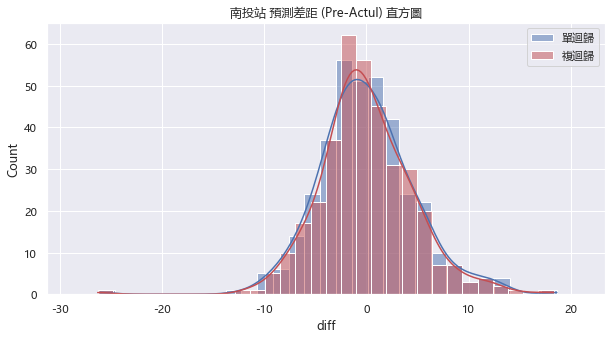

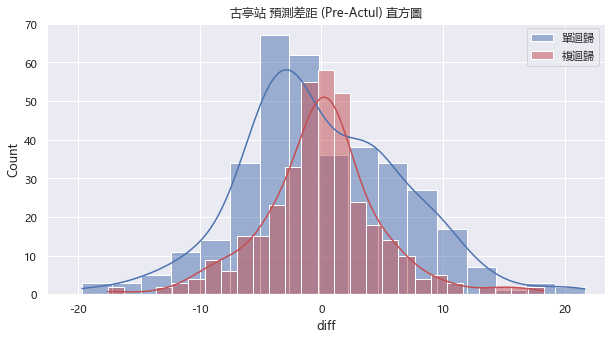

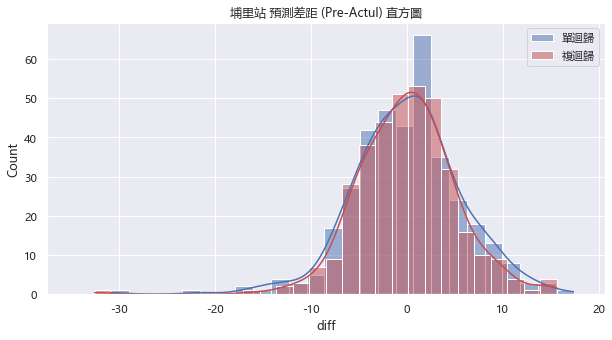

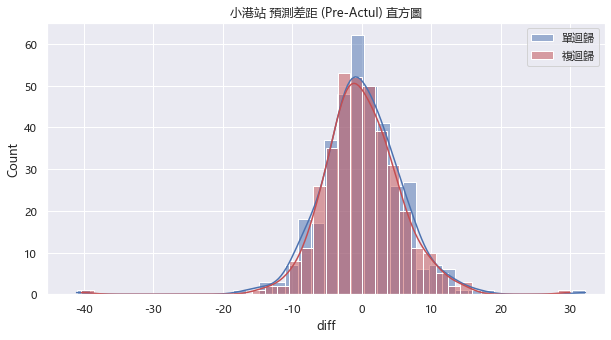

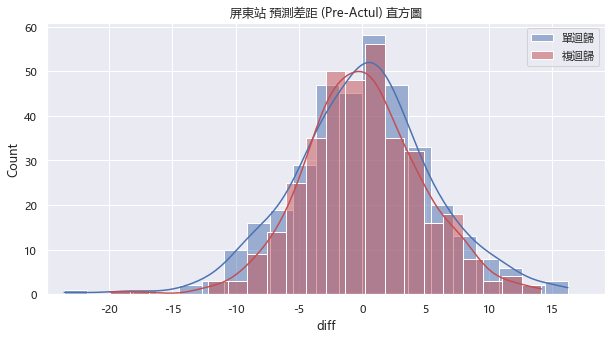

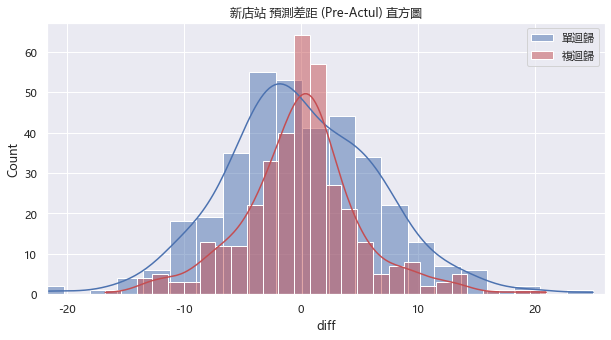

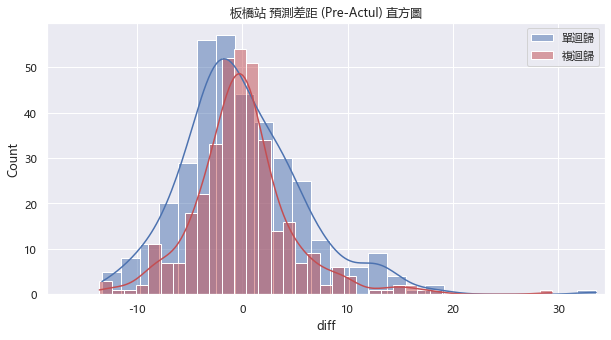

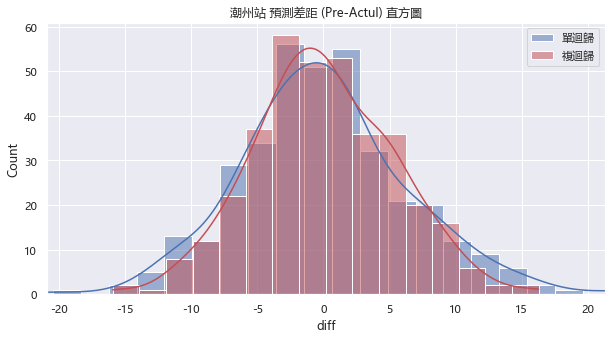

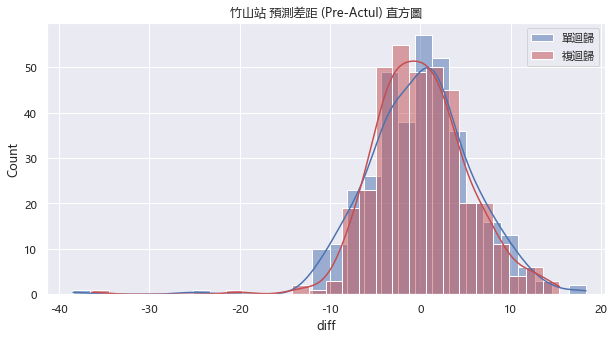

In [147]:
for s, single_reg_diff in zip(Site_lst, single_reg_diff_lst):
    # mask
    mask_train = (df_result["SiteName"].isin([s])) & (df_result["date"].apply(lambda d: d.year)==2018)
    mask_test_self = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2018)
    mask_test_next = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2019)
    
    #split dataset
    #     for model
    X_train = df_result[mask_train][X_col_model].values
    y_train = df_result[mask_train]['O3_8hr_max'].values.reshape(-1,1) 

    #  for test_self
    X_test_self = df_pic_for_model[mask_test_self][X_col_test].values
    y_test_self = df_pic_for_model[mask_test_self]['O3_8hr'].values.reshape(-1,1)
    
    # for test_next
    X_test_next = df_pic_for_model[mask_test_next][X_col_test].values
    y_test_next = df_pic_for_model[mask_test_next]['O3_8hr'].values.reshape(-1,1)
    
    # normalized
    feature_range = (0, 100)
    min_max_scaler_multi_X = preprocessing.MinMaxScaler(feature_range=feature_range)
    min_max_scaler_y = preprocessing.MinMaxScaler(feature_range=feature_range)
    X_train = min_max_scaler_multi_X.fit_transform(X_train)
    y_train = min_max_scaler_y.fit_transform(y_train)
    
    # model
    reg = LinearRegression(fit_intercept=True)  
    reg.fit(X_train, y_train) # 訓練模型
    y_train_pred = reg.predict(X_train) # 預測
    
    # model summery by statsmodels.api as sm
    X_train_2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X_train_2)
    est2 = est.fit()
    
    # normalized back
    X_train = min_max_scaler_multi_X.inverse_transform(X_train)
    y_train = min_max_scaler_y.inverse_transform(y_train)
    y_train_pred = min_max_scaler_y.inverse_transform(y_train_pred)
    

    
    # Print outputs
    print(f">> X:{X_col_model}")
    print(f">> slope:{reg.coef_}")
    print(f">> pvalue:{est2.pvalues.round(3)[1:].tolist()}")
    print(f">> intercept: {round(reg.intercept_[0],3)}")
    print(f">> r2_score: {round(r2_score(y_train, y_train_pred),3)}\n")
#     print(est2.summary())
    
    
    # 單變數迴歸 diff: single_reg_diff
    
    # 複迴歸 diff: mutil_reg_diff
    mutil_reg_diff = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()})
    mutil_reg_diff.loc[:, "diff"] = mutil_reg_diff.loc[: ,"Predicted"] - mutil_reg_diff.loc[: ,"Actual"]

    # 疊圖
    fig, ax = plt.subplots(figsize=(10,5))
    for idx, d in enumerate([single_reg_diff, mutil_reg_diff]):
        if idx==1:
            color = 'r'
            label = "複迴歸"
        else:
            color = 'b'
            label = "單迴歸"
            
        sns.histplot(data=d, x="diff" ,ax=ax, kde=True, color=color, label=label)
    ax.set_xlim(mutil_reg_diff.loc[:, "diff"].min()-5, mutil_reg_diff.loc[:, "diff"].max()+5)
    ax.legend()
    ax.set_title(f"{s}站 預測差距 (Pre-Actul) 直方圖")
    
    print('>> Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))   
    print('>> Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    print(f"\n")

    # 當年度驗證
    print(f"*******{s} 當年度驗證*******\n")

    # normalized
    X_test_self = min_max_scaler_multi_X.transform(X_test_self)

    # 以模型預測每小時資料
    y_test_self_pred = reg.predict(X_test_self)

    # normalized back
    X_test_self = min_max_scaler_multi_X.inverse_transform(X_test_self)
    y_test_self_pred = min_max_scaler_y.inverse_transform(y_test_self_pred)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_self = df_pic_for_model[mask_test_self].reset_index(drop=True).copy(deep=True)
    df_self.loc[:,"y_pred"] = y_test_self_pred
    df_self.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_self_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_self = df_self.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_self["is_exceed_date"].values, df_self[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()
    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_self["is_exceed_date"].isin([True])) &(df_self[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_self[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_self[mask_TP]['real_exceed_hour']) -(df_self[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

    # 下年度驗證
    print(f"*******{s} 下年度驗證*******\n")

    # normalized
    X_test_next = min_max_scaler_multi_X.transform(X_test_next)

    # 以模型預測每小時資料
    y_test_next_pred = reg.predict(X_test_next)

    # normalized back
    X_test_next = min_max_scaler_multi_X.inverse_transform(X_test_next)
    y_test_next_pred = min_max_scaler_y.inverse_transform(y_test_next_pred)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_next = df_pic_for_model[mask_test_next].reset_index(drop=True).copy(deep=True)
    df_next.loc[:,"y_pred"] = y_test_next_pred
    df_next.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_next_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_next = df_next.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_next["is_exceed_date"].values, df_next[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_next["is_exceed_date"].isin([True])) &(df_next[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_next[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_next[mask_TP]['real_exceed_hour']) -(df_next[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")